In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from statistics import median, mean
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [2]:
# Load models (axial and vector)
inputFiles = ['../scanResultas_axial.pcl', '../scanResults_vector.pcl', '../scanResults_vector_add.pcl', '../scanResults_axial_add.pcl']
dfs = [pd.read_pickle(i) for i in inputFiles]
recastData = pd.concat(dfs, ignore_index=True)

### Get model points

In [3]:
models = []
mCols = ['Coupling', 'Mode', '$m_{med}$', '$m_{DM}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols, row.tolist()))
    if m not in models:
        models.append(m)

print('%i models loaded.' %len(models))

388 models loaded.


### Get model parameters

In [4]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': ['Vector', 'Axial'], 'Mode': 'DM+QCDjets', '$m_{med}$': [450.0, 1250.0, 100.0, 2500.0, 200.0, 1000.0, 2250.0, 300.0, 750.0, 400.0, 2000.0, 500.0, 1750.0, 3000.0, 250.0, 1500.0, 2750.0], '$m_{DM}$': [1.0, 1400.0, 900.0, 650.0, 400.0, 150.0, 30.0, 800.0, 40.0, 300.0, 45.0, 1200.0, 50.0, 55.0, 700.0, 60.0, 450.0, 70.0, 200.0, 75.0, 1100.0, 80.0, 600.0, 90.0, 1500.0, 350.0, 100.0, 1000.0, 750.0, 500.0, 120.0, 250.0]}
Coupling = ['Vector', 'Axial']
Mode = DM+QCDjets


### Obtain efficiencies from the cutflow

In [5]:
# Select year
recastData = recastData[recastData['Data-takingperiod'] == 2017]

In [6]:
# label = [c for c in recastData if (c.startswith("HCAL") and not "jets" in c)]

eff = recastData[['Coupling', '$m_{med}$', '$m_{DM}$', 'HCALmitigation($\\phi^{miss}$)']]

In [7]:
effAx = eff[eff['Coupling'] == 'Axial']
effVec = eff[eff['Coupling'] == 'Vector']

In [8]:
# Setting the index with mass pairs
effAx = pd.DataFrame([effAx.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in eff if 'HCALmitigation($\\phi^{miss}$)' in c])
effVec = pd.DataFrame([effVec.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in eff if 'HCALmitigation($\\phi^{miss}$)' in c])

In [9]:
diff = []
for med, dm in effVec:
    d = np.abs(effAx[med, dm] - effVec[med, dm])/effAx[med, dm]
    d = d.replace(np.inf, 0)
    d = d.max()
    diff.append(d)

In [10]:
masspts = recastData[recastData['Coupling'] == 'Axial']
masspts = masspts[['$m_{med}$', '$m_{DM}$']]

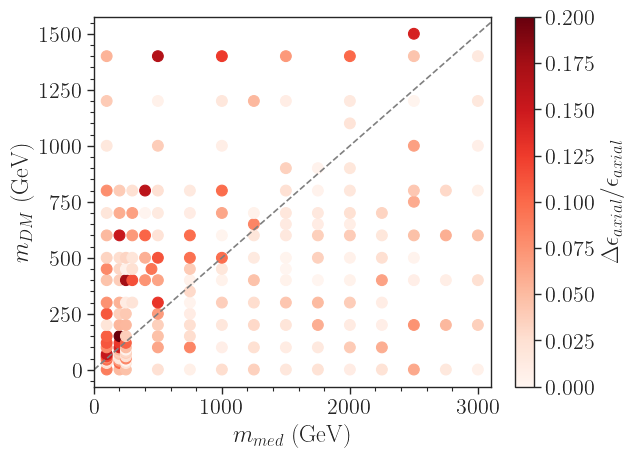

In [11]:
# Plot results
plt.scatter(x=masspts['$m_{med}$'], y=masspts['$m_{DM}$'], vmin=0.0, vmax=.2,
            cmap=plt.cm.get_cmap('Reds'), c=diff, s=60)

plt.axline((0, 0), slope=1/2, linestyle='--', color='gray')

cbar=plt.colorbar(label=r'$\Delta \epsilon_{axial}/\epsilon_{axial}$')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.minorticks_on()
# plt.ylim(0,1500)
plt.show()

In [12]:
pts = np.array([x for x in product(np.linspace(0.,3000.,100),np.linspace(0.,1500.,100))])
relDiffPts = griddata(list(zip(masspts['$m_{med}$'],masspts['$m_{DM}$'])),
                  diff,pts)
pts = pts[~np.isnan(relDiffPts)]
relDiffPts = relDiffPts[~np.isnan(relDiffPts)]

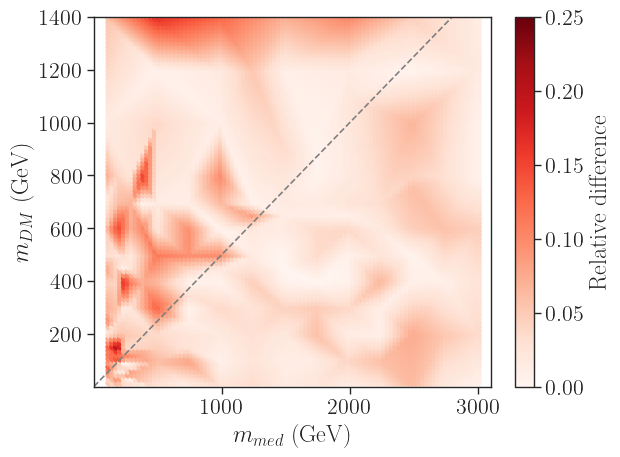

In [13]:
plt.scatter(x=pts[:,0], y=pts[:,1], vmin=0., vmax =.25, 
            c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
cbar = plt.colorbar(label='Relative difference')
plt.axline((1, 1), slope=1/2, linestyle='--', color='gray')

plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(1,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(1,1400)
plt.show()